In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from scipy.sparse.linalg import svds

from surprise import (SVD
                      , SVDpp
                      , NMF
                      , NormalPredictor
                      , BaselineOnly)
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection.validation import cross_validate
from surprise import accuracy

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from matplotlib import rcParams, cm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.models import (load_data
                        , data_summary
                        , combine_tables
                        , collab_mat
                        , svd_mat
                        , svd_model
                        , surprise_bench
                        , top_biz_pred
                        , NMF_Mat
                        , NN_Model
                        , NN_Results_df
                        , con_bas_biz_rec
                       )

### Load Data

In [4]:
biz_df, rev_df, ckin_df, pho_df, tip_df, user_df = load_data()

In [5]:
data_summary(biz_df
             , rev_df
             , ckin_df
             , pho_df
             , tip_df
             , user_df)

name,rows,colums
business,192609,14
review,6685900,9
checkin,161950,2
photo,200000,4
tip,1223094,5
user,1637138,22


In [6]:
user_rev_biz = combine_tables(user_df
                              , rev_df
                              , biz_df)

In [7]:
user_rev_biz.city.value_counts()[0:5]

Las Vegas     1757375
Phoenix        645716
Toronto        434349
Scottsdale     329826
Charlotte      273989
Name: city, dtype: int64

In [8]:
user_rev_biz_scott = user_rev_biz.loc[user_rev_biz.city == 'Scottsdale']
user_rev_biz_scott.shape

(329826, 36)

In [9]:
len(user_rev_biz_scott.user_id.unique())

140940

In [10]:
len(user_rev_biz_scott.business_id.unique())

7081

In [11]:
average_user_stars_given = pd.DataFrame(user_rev_biz_scott.average_stars.value_counts())

In [12]:
user_rev_biz_scott.average_stars.mean()

3.849698052912747

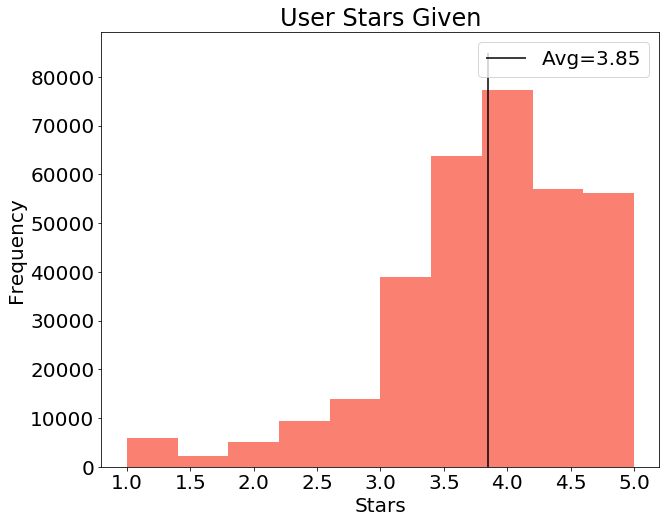

In [13]:
plt.figure(figsize=(10,8))

plt.hist(user_rev_biz_scott.average_stars, color='salmon')
plt.vlines(3.85, 0, 85000, label = 'Avg=3.85')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('User Stars Given')
plt.legend();
plt.savefig('png/user_stars_given.png')

In [14]:
biz_stars_df = pd.DataFrame(user_rev_biz_scott.biz_star.value_counts().sort_index())

In [15]:
user_rev_biz_scott.biz_star.mean()

3.9298751462892554

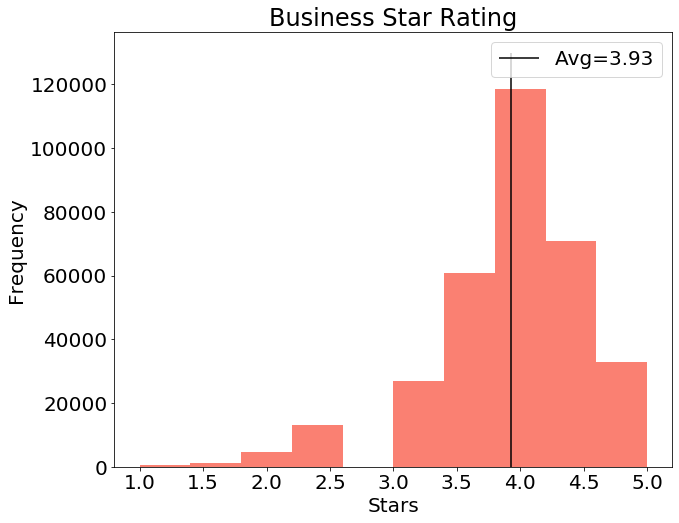

In [16]:
plt.figure(figsize=(10,8))
plt.hist(user_rev_biz_scott.biz_star, color='salmon')
plt.vlines(3.93, 0, 130000, label='Avg=3.93')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('Business Star Rating')
plt.legend();
plt.savefig('png/biz_stars_rating.png')

In [17]:
user_rev_biz_scott.biz_review_count.median()

191.0

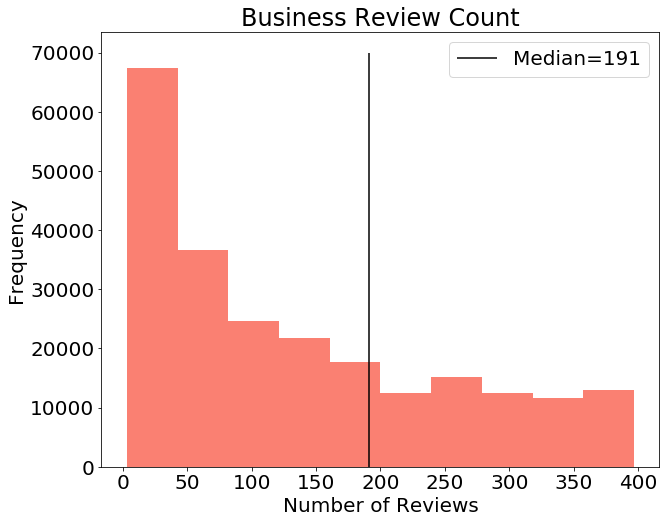

In [18]:
plt.figure(figsize=(10,8))
plt.hist(user_rev_biz_scott.biz_review_count.loc[user_rev_biz_scott.biz_review_count < 400], color='salmon')
plt.vlines(191, 0, 70000, label='Median=191')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('Business Review Count')
plt.legend();
plt.savefig('png/biz_rev_count.png')

In [19]:
user_rev_biz_scott.user_review_count.median()

21.0

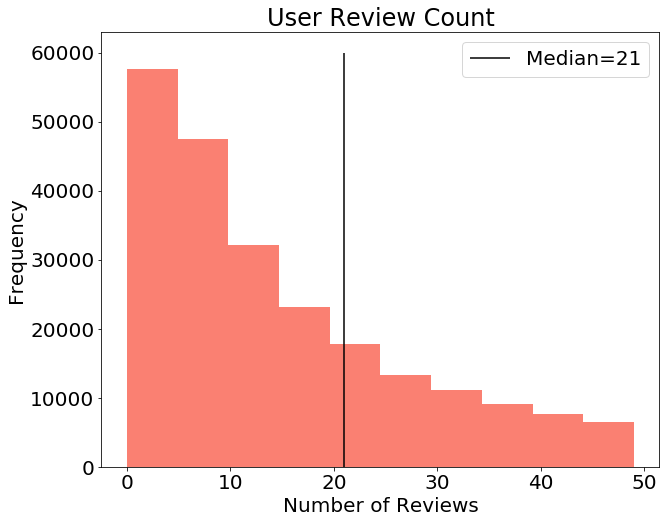

In [20]:
plt.figure(figsize=(10,8))
plt.hist(user_rev_biz_scott.user_review_count.loc[user_rev_biz_scott.user_review_count < 50], color='salmon')
plt.vlines(21, 0, 60000, label='Median=21')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('User Review Count')
plt.legend();
plt.savefig('png/user_rev_count.png')

In [21]:
n = 34
cat_short = []
for cat in user_rev_biz_scott.categories.value_counts()[0:n].index:
    cat_short.append(cat[:9])
cat_short = np.array(cat_short)
cat_short

array(['Mexican, ', 'Restauran', 'Nightlife', 'Latin Ame', 'American ',
       'Cocktail ', 'American ', 'Nightlife', 'Mexican, ', 'Sandwiche',
       'Restauran', 'Food, Mex', 'Brazilian', 'Restauran', 'Vegetaria',
       'Pizza, Re', 'Coffee & ', 'Nightlife', 'American ', 'American ',
       'Farmers M', 'Salad, Bu', 'Restauran', 'Food, Res', 'Event Pla',
       'American ', 'Steakhous', 'Sandwiche', 'Breakfast', 'Sandwiche',
       'Persian/I', 'American ', 'Restauran', 'Cafes, Am'], dtype='<U9')

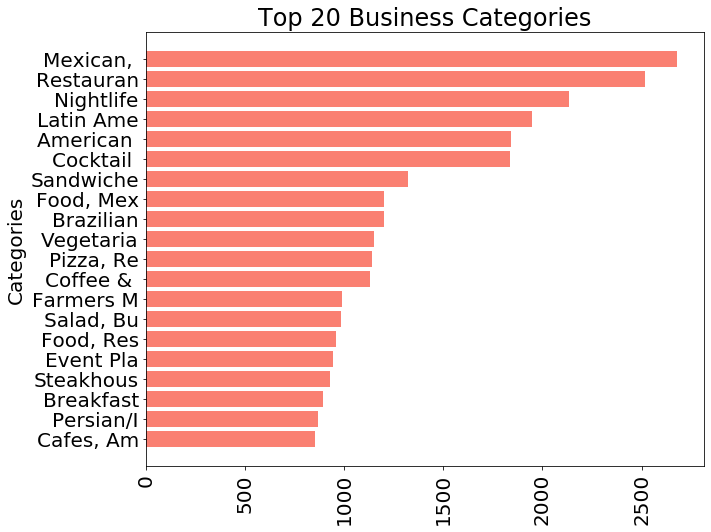

In [22]:
plt.figure(figsize=(10,8))

plt.barh(cat_short
       , user_rev_biz_scott.categories.value_counts()[0:n].values, color='salmon')
plt.xticks(rotation=90)
plt.ylabel('Categories')
plt.gca().invert_yaxis()
plt.title('Top 20 Business Categories');
plt.savefig('png/top_20_biz_cat.png')

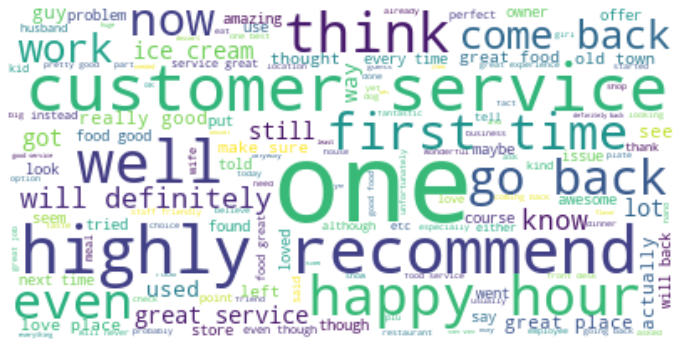

In [23]:
all_rev_words_scott = ' '.join(user_rev_biz_scott.rev_text.str.lower())

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=200).generate(all_rev_words_scott)

# Display the wordcloud image:
plt.figure(figsize=[12,9])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show(); 
# plt.savefig('png/wordcloud_reviews.png');

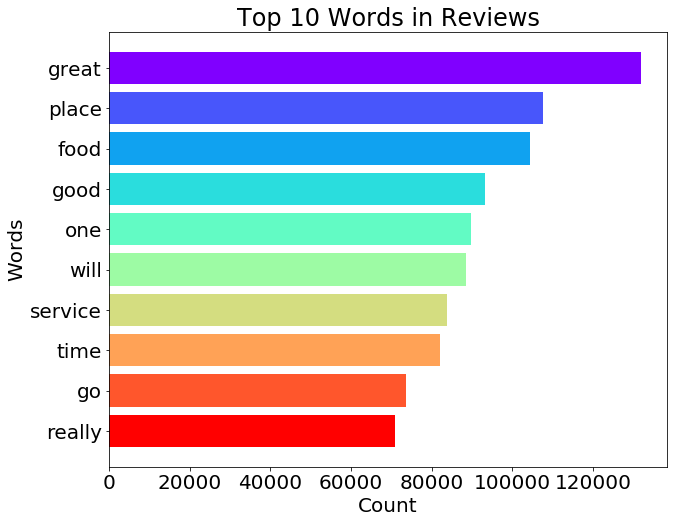

In [24]:
stopwords = STOPWORDS

filtered_words = [word for word in all_rev_words_scott.split() if word not in stopwords]
counted_words = Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=[10, 8])

plt.title('Top 10 Words in Reviews')
plt.xlabel('Count')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.barh(words, counts, color=colors);
plt.savefig('png/top_10_words_rev.png')

In [25]:
biz_id_scott = user_rev_biz_scott.business_id.unique()

In [26]:
biz_id_scott

array(['lV3qjLJF_5QujITWHZ64gg', 'p-8AMN9Q0qwym-3Pdle20Q',
       '-LRlx2j9_LB3evsRRcC9MA', ..., '5HPBIG3BVMIfy4_-D9zPIQ',
       'k-qjgxB45hV0627P6KRYJQ', 'a4PI8XlT_nXrH93vAo28UQ'], dtype=object)

In [27]:
len(biz_id_scott)

7081

In [28]:
tip_df.columns

Index(['user_id', 'business_id', 'text', 'date', 'compliment_count'], dtype='object')

In [29]:
tip_df.shape

(1223094, 5)

In [30]:
tip_df_scott = tip_df[tip_df.business_id.isin(biz_id_scott)]

In [31]:
tip_df_scott.shape

(51387, 5)

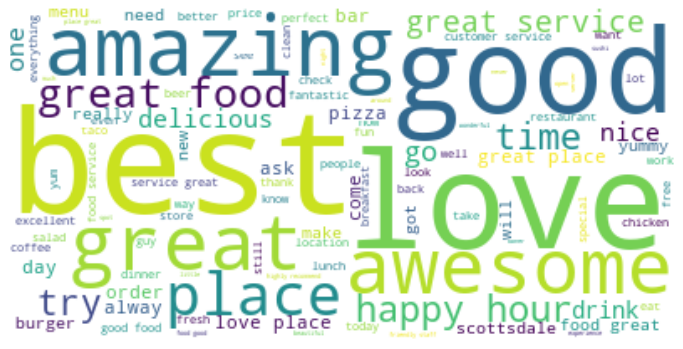

In [32]:
all_tip_words_scott = ' '.join(tip_df_scott.text.str.lower())

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=100).generate(all_tip_words_scott)

# Display the wordcloud image:
plt.figure(figsize=[12,9])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");
# plt.savefig('png/wordcloud_tips.png');

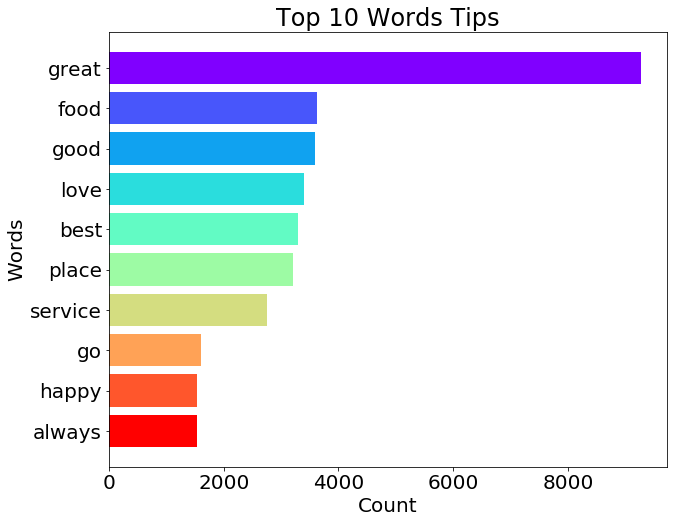

In [33]:
stopwords = STOPWORDS
stopwords.add('&')


filtered_words = [word for word in all_tip_words_scott.split() if word not in stopwords]
counted_words = Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=[10, 8])

plt.title('Top 10 Words Tips')
plt.xlabel('Count')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.barh(words, counts, color=colors);
plt.savefig('png/top_10_words_tip.png')

In [34]:
ckin_df.shape

(161950, 2)

In [35]:
ckin_df_scott = ckin_df[ckin_df.business_id.isin(biz_id_scott)]

In [36]:
ckin_df_scott.shape

(5638, 2)

In [37]:
ckin_df_scott.columns

Index(['business_id', 'date'], dtype='object')

In [38]:
ckin_df_scott['date'].iloc[0]

'2010-03-23 05:49:25, 2010-08-27 05:38:45, 2010-09-05 23:37:14, 2010-09-10 02:13:41, 2010-10-26 19:01:51, 2010-12-10 21:23:20, 2010-12-23 21:47:12, 2011-01-04 20:23:02, 2011-01-16 21:18:05, 2011-01-22 06:05:02, 2011-01-22 20:24:46, 2011-01-22 21:42:04, 2011-02-02 16:31:12, 2011-02-03 18:46:48, 2011-02-19 04:02:34, 2011-03-18 18:51:57, 2011-04-16 02:49:44, 2011-04-16 02:50:57, 2011-04-22 05:38:01, 2011-04-27 14:45:58, 2011-05-19 14:40:43, 2011-05-20 00:01:04, 2011-05-26 20:01:58, 2011-05-31 14:43:41, 2011-06-01 14:46:34, 2011-06-03 03:44:22, 2011-06-05 15:50:45, 2011-06-05 21:58:51, 2011-06-10 14:46:09, 2011-06-10 18:49:33, 2011-06-11 13:43:32, 2011-06-11 20:46:51, 2011-06-12 00:47:30, 2011-06-12 22:48:05, 2011-06-13 02:59:13, 2011-06-13 14:16:25, 2011-06-13 23:34:56, 2011-06-15 00:03:00, 2011-06-15 23:47:11, 2011-06-16 04:01:12, 2011-06-16 14:47:48, 2011-06-17 00:05:25, 2011-06-17 15:26:03, 2011-06-20 17:53:19, 2011-06-22 18:46:58, 2011-06-22 18:49:22, 2011-07-01 05:01:10, 2011-07-01 0

In [39]:
ckin_df_scott.head()

,business_id,date
45,-01XupAWZEXbdNbxNg5mEg,"2010-03-23 05:49:25, 2010-08-27 05:38:45, 2010..."
101,-1BPe8UjF2_l3nVk-DFUjA,"2015-12-03 18:44:00, 2016-03-17 18:19:21, 2016..."
151,-2TKoFglMQvSmHSNWf6S8Q,"2012-08-14 01:38:56, 2012-09-18 23:27:48, 2012..."
183,-37_L44VjFw1U4tBfBDHRw,"2015-01-21 18:10:30, 2015-02-14 01:31:49, 2015..."
216,-4-2NZvqC68eOCiwmCQTiQ,"2018-05-16 19:50:42, 2018-09-08 00:44:43"


In [40]:
ckin_df_scott['checkins'] = ckin_df_scott.date.str.split(', ').apply(len)

In [41]:
ckin_df_scott.head()

,business_id,date,checkins
45,-01XupAWZEXbdNbxNg5mEg,"2010-03-23 05:49:25, 2010-08-27 05:38:45, 2010...",307
101,-1BPe8UjF2_l3nVk-DFUjA,"2015-12-03 18:44:00, 2016-03-17 18:19:21, 2016...",3
151,-2TKoFglMQvSmHSNWf6S8Q,"2012-08-14 01:38:56, 2012-09-18 23:27:48, 2012...",6
183,-37_L44VjFw1U4tBfBDHRw,"2015-01-21 18:10:30, 2015-02-14 01:31:49, 2015...",8
216,-4-2NZvqC68eOCiwmCQTiQ,"2018-05-16 19:50:42, 2018-09-08 00:44:43",2


In [42]:
ckin_df_scott.checkins.value_counts()

1       572
2       365
3       284
4       247
5       153
       ... 
330       1
326       1
298       1
286       1
1999      1
Name: checkins, Length: 891, dtype: int64

In [43]:
ckin_df_scott.checkins.median()

21.0

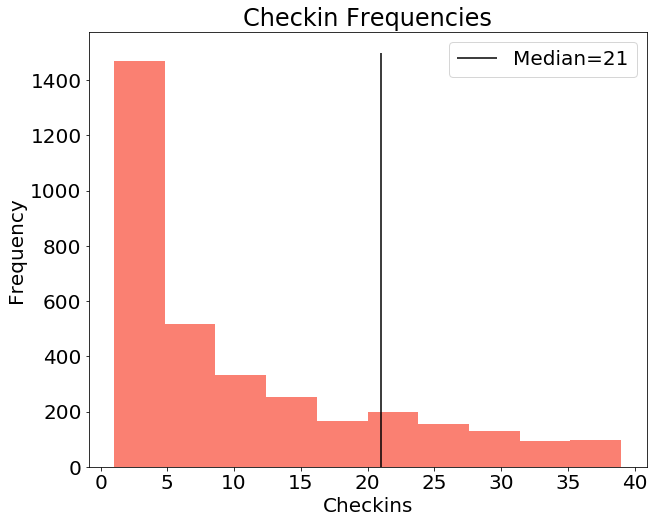

In [44]:
plt.figure(figsize=[10,8])
plt.hist(ckin_df_scott.checkins.loc[ckin_df_scott.checkins < 40], color = 'salmon')
plt.vlines(21, 0, 1500, label='Median=21')
plt.xlabel('Checkins')
plt.ylabel('Frequency')
plt.title('Checkin Frequencies')
plt.legend();
plt.savefig('png/checkin_frequencies.png')

### SVD

In [45]:
user_biz_collab_mat = collab_mat('Scottsdale'
                                 , user_rev_biz)

In [46]:
sigma, user_biz_predictions = svd_mat(user_biz_collab_mat, k=40)

### SVD Predictions

In [47]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = user_biz_predictions
             , n=10)

('Kristin',
 ['True Food Kitchen',
  'Cafe Monarch',
  'The Herb Box',
  'Sweet Republic',
  'Talking Stick Resort',
  'Roka Akor - Scottsdale',
  'Sprinkles Cupcakes',
  "Portillo's Hot Dogs",
  'iPic Theaters',
  'Studio Movie Grill'])

In [48]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:10]

3360        Butters Pancakes & Café
312378                   Wildflower
600627                 Flower Child
624904                 Viet Kitchen
744479                   Wildflower
746301     Original Breakfast House
771054      Andreoli Italian Grocer
838710                 Barrio Queen
1147492        Rocket Burger & Subs
1155989                 Rustic Cafe
Name: biz_name, dtype: object

### NMF

In [49]:
nmf_mat = NMF_Mat(user_biz_collab_mat)

### NMF Predictions

In [50]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = nmf_mat
             , n=10)

('Kristin',
 ['True Food Kitchen',
  'Hopdoddy Burger Bar',
  'The Thumb BBQ',
  'SOL Mexican Cocina',
  'Butters Pancakes & Café',
  "Coconut's Fish Cafe",
  'Salty Sow',
  'North Italia',
  "Portillo's Hot Dogs",
  'Sweet Republic'])

In [51]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:10]

3360        Butters Pancakes & Café
312378                   Wildflower
600627                 Flower Child
624904                 Viet Kitchen
744479                   Wildflower
746301     Original Breakfast House
771054      Andreoli Italian Grocer
838710                 Barrio Queen
1147492        Rocket Burger & Subs
1155989                 Rustic Cafe
Name: biz_name, dtype: object

### Validation

In [52]:
data, svd_acc, svd_cv = svd_model(df = user_rev_biz)

RMSE: 0.7059


In [53]:
svd_acc

0.7058718382419816

In [54]:
svd_cv

array([0.70180078, 0.70007411, 0.69425898, 0.69841586, 0.70300875])

In [55]:
NMF_results = cross_validate(NMF(), data, cv = 5)

In [56]:
NMF_results['test_rmse']

array([0.64386955, 0.63937895, 0.63717097, 0.63162079, 0.64266102])

In [57]:
bench_df = surprise_bench(df=user_rev_biz)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [58]:
bench_df

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.691553,0.478216,5.360216,0.303873
NMF,0.701788,0.535075,18.524514,0.361336
BaselineOnly,0.715208,0.506270,2.084284,0.306525
NormalPredictor,1.099921,0.864677,0.582511,0.453163


### Neural Network Predictor

In [59]:
# Source: https://www.youtube.com/watch?v=4vwNkHFuZBk

In [60]:
from tensorflow.keras.layers import (Input
                                     , Embedding
                                     , Dot
                                     , Flatten
                                    )
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import Callback

import os

In [62]:
user_id_dict, biz_id_dict, user_df, biz_df, X, X_test, model, history = NN_Model(df = user_rev_biz
                                                                                 , n_factors = 10
                                                                                 , ep = 16)


Testing loss: 13.972044689264932, acc: 0.0


Testing loss: 10.206517683802899, acc: 0.0004972288734279573


Testing loss: 8.2220497374806, acc: 0.0011036054929718375


Testing loss: 7.152508585348682, acc: 0.001467431546188891


Testing loss: 6.552307478416431, acc: 0.0015765792923048139


Testing loss: 6.19530198773488, acc: 0.0016129618743434548


Testing loss: 5.988184054647287, acc: 0.0016735995886847377


Testing loss: 5.869163104445376, acc: 0.0015765792923048139


Testing loss: 5.796763119668136, acc: 0.0016857271548360586


Testing loss: 5.749054270822196, acc: 0.0016129618743434548


Testing loss: 5.717364028320827, acc: 0.0016614720225334167


Testing loss: 5.69821242415697, acc: 0.0015523242764174938


Testing loss: 5.6822034114588895, acc: 0.0016250894404947758


Testing loss: 5.668045834375318, acc: 0.0015765792923048139


Testing loss: 5.6577604609729235, acc: 0.0016372170066460967


Testing loss: 5.649560857059431, acc: 0.0015523242764174938

Instructions for updating:


In [63]:
test_loss = [13.972044689264932
             , 10.206517683802899
             , 8.2220497374806
             , 7.152508585348682
             , 6.552307478416431
             , 6.19530198773488
             , 5.988184054647287
             , 5.869163104445376
             , 5.796763119668136
             , 5.749054270822196
             , 5.717364028320827
             , 5.69821242415697
             , 5.6822034114588895
             , 5.668045834375318
             , 5.6577604609729235
             , 5.649560857059431
            ]

test_accuracy = [0.0
                 , 0.0004972288734279573
                 , 0.0011036054929718375
                 , 0.001467431546188891
                 , 0.0015765792923048139
                 , 0.0016129618743434548
                 , 0.0016735995886847377
                 , 0.0015765792923048139
                 , 0.0016857271548360586
                 , 0.0016129618743434548
                 , 0.0016614720225334167
                 , 0.0015523242764174938
                 , 0.0016250894404947758
                 , 0.0015765792923048139
                 , 0.0016372170066460967
                 , 0.0015523242764174938
                ]

In [64]:
print(len(test_loss))
print(len(test_accuracy))

16
16


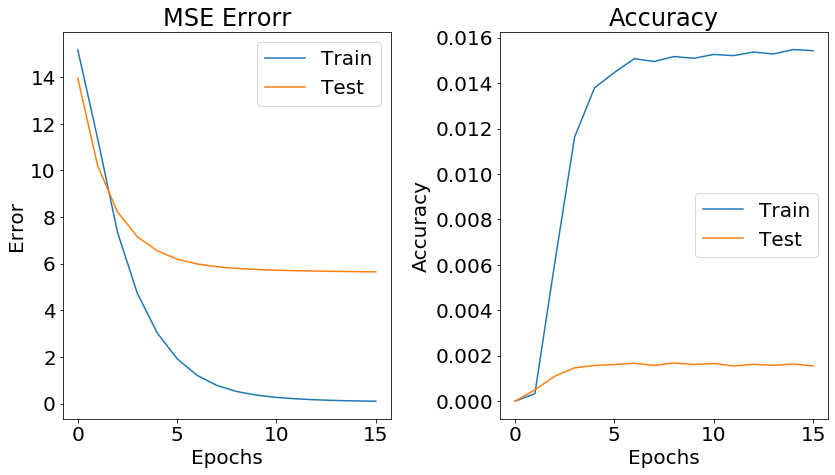

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12,7), tight_layout=True)
ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(test_loss, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error')
ax[0].set_title('MSE Errorr')
ax[0].legend()
    
ax[1].plot(history.history['accuracy'], label='Train')
ax[1].plot(test_accuracy, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend();
plt.savefig('png/NN_loss_acc.png')

In [66]:
NN_Results_df(mod = model
             , xtest = X_test
             , n=15)

,user_name,biz_name,average_stars,Prediction
1600473,Mirco,Merci French Cafe & Patisserie,4.81,4.093554
773319,Scott,McCormick-Stillman Railroad Park,3.62,3.611058
2675092,Ashley,Zoes Kitchen,4.11,4.145786
3141992,Dawn,Scottsdale Nails,4.70,4.279809
2063207,Shaila,Saints & Scissors Salon,4.71,-0.254252
3693030,Shaya,Persian Room,4.06,3.740862
6037906,Marnie,Sir Grout Phoenix,3.75,0.056363
1878741,Chelsea,Houston's Restaurant,4.25,4.556706
4351605,Horace,Nekter Juice Bar,4.75,4.430846
4458509,Stephanie,Blue Adobe Santa Fe Grille,3.75,4.355655


In [67]:
user_id_dict

{'---PLwSf5gKdIoVnyRHgBA': 0,
 '--2HUmLkcNHZp0xw6AMBPg': 1,
 '--3B8LdT1NCD-bPkwS5-5g': 2,
 '--3WaS23LcIXtxyFULJHTA': 3,
 '--41c9Tl0C9OGewIR7Qyzg': 4,
 '--4rAAfZnEIAKJE80aIiYg': 5,
 '--5XzJ2pRsVVJiJUfzZlgQ': 6,
 '--CIuK7sUpaNzalLAlHJKA': 7,
 '--CJT4d-S8UhwqHe05QgfQ': 8,
 '--DxiDMQgN08E5gTM0aj7Q': 9,
 '--E_9aMNd1pgJFxe-oJ1OQ': 10,
 '--NceChXmZgyx57MtQFjyw': 11,
 '--Nnm_506G_p8MxAOQna5w': 12,
 '--PHyzUR6FEjHqxg9I60LA': 13,
 '--RY4bG7REOBum5HsSspxQ': 14,
 '--Rm-VyYWgHA7ZpljAMlvg': 15,
 '--ZB6p_MzwilQI0unCJVsQ': 16,
 '--_N9jPdYR9WdJKQhekANg': 17,
 '--bHHroMDGhmn9cIxKo9GQ': 18,
 '--bzLMRvwBo87e0Fb6ihUw': 19,
 '--eQVss9nAx54FWsZHZgpA': 20,
 '--egmQREiy-OJbJELjNwuA': 21,
 '--fF_pQlaU9sME-HLCoHlQ': 22,
 '--gBGXfVm5YyAVVkj84W5Q': 23,
 '--haaCngcz4NnX_IVSFswA': 24,
 '--iiD1TQzaXGxePZ1g5S2A': 25,
 '--kvGeSg0-nfm3pB9ED5Vw': 26,
 '--mQ4S5h1tXzvE9VDYVwdQ': 27,
 '--mSYQD4piZRagYS73frlQ': 28,
 '--nQ4-F7JINAlPir_f-VeQ': 29,
 '--oVdTxVd7QVr8Y0Ukz9uw': 30,
 '--qpuVw7_i9YB4Tlib1-9A': 31,
 '--rfv5EuomS0Rjkg

In [68]:
 biz_id_dict

{'-01XupAWZEXbdNbxNg5mEg': 0,
 '-1BPe8UjF2_l3nVk-DFUjA': 1,
 '-2TKoFglMQvSmHSNWf6S8Q': 2,
 '-37_L44VjFw1U4tBfBDHRw': 3,
 '-4-2NZvqC68eOCiwmCQTiQ': 4,
 '-4G-LJhOeTbAfQuaxCYeHA': 5,
 '-4TMQnQJW1yd6NqGRDvAeA': 6,
 '-4_n--u4Z_SBbgz1zUKpYw': 7,
 '-4dzsToZl39O95C5KWbJbg': 8,
 '-6h3K1hj0d4DRcZNUtHDuw': 9,
 '-6pjRBsLbkHyGcohvu_Jkw': 10,
 '-79cl_yASWXiv7RmzirNxA': 11,
 '-7ZjpebPJPYsAkOCDAZ-Sw': 12,
 '-8bGynxpc8t4-vhOy6FxTg': 13,
 '-9D4JHiKgd-1Eay-KbVpwA': 14,
 '-9ly39RQ8CvqxPuNZrGEbA': 15,
 '-9nai28tnoylwViuJVrYEQ': 16,
 '-AcyJ7-rjKPdEYJa-gplZg': 17,
 '-B0cfDL0_7PR1rLt0ThiQw': 18,
 '-B2WY_he81rS3Lnl0IWvPA': 19,
 '-BrMNg4MbpftOUTjOMVp9g': 20,
 '-CPD0t8h2Acd0r93779sKw': 21,
 '-CTmg9JYXWQkXnnW9uw8vA': 22,
 '-CdnZk0AULum7B_ThcZV-A': 23,
 '-DIZwl4igqddB_RQr_u3sg': 24,
 '-DgLrAuOKilHSeH8gFheEw': 25,
 '-FCUVf01SPTwVm5tCyu8Lw': 26,
 '-FLnsWAa4AGEW4NgE8Fqew': 27,
 '-GUi0xyzwT9KJPS0v96dRA': 28,
 '-GpsXedO2BOL0EGBe_bDuQ': 29,
 '-J1OaCKXduY9uHf8qGxYsA': 30,
 '-JFaysaI_sNmTarsl12jng': 31,
 '-L7W3egf0xOyT2oZ

In [69]:
X[X.user_num==1].biz_name.values

array(['Butters Pancakes & Café', 'Wildflower', 'Flower Child',
       'Andreoli Italian Grocer', 'Barrio Queen',
       'Grassroots Kitchen & Tap', 'La Fonda Del Sol', 'Diego Pops',
       "Jason's Deli", 'Zipps Sports Grill', 'Arrivederci', "Corleone's",
       'Jalapeno Inferno', 'Mozaik Skin & Body', 'NYPD Pizza',
       'NYPD Pizza', 'Naked BBQ', "Casella's Italian Delicatessen",
       "Casella's Italian Delicatessen", "D'Lite Healthy On The Go",
       'Dairy Queen', 'Asian Island', "Raising Cane's",
       'Wow Wow Lemonade Scottsdale', "Coconut's Fish Cafe",
       'Paradise Hills Dentistry', 'Paradise Hills Dentistry',
       'Connected Medical Center'], dtype=object)

In [70]:
predictions = model.predict([np.array([1 for _ in range(7081)])
                             , biz_df.index.values])

In [71]:
kristin_df = biz_df
kristin_df['user_name'] = 'Kristin'
kristin_df['user_num'] = 1
kristin_df['model_pred'] = predictions
kristin_df.head()

,business_id,biz_name,user_name,user_num,model_pred
0,-01XupAWZEXbdNbxNg5mEg,18 Degrees,Kristin,1,4.512844
1,-1BPe8UjF2_l3nVk-DFUjA,Journey Massage Therapy,Kristin,1,3.652511
2,-2TKoFglMQvSmHSNWf6S8Q,U.S. Bank,Kristin,1,3.798334
3,-37_L44VjFw1U4tBfBDHRw,Cloud Nine Wellness Spa,Kristin,1,2.379955
4,-4-2NZvqC68eOCiwmCQTiQ,Elle Nails,Kristin,1,2.770494


In [72]:
kristin_df.nlargest(28, ['model_pred']).biz_name.values

array(['John Gluch - Platinum Living Realty', 'Riddle Escape Room',
       'Wave House Cleaning Service', 'Nu Nails', 'Sasaki Sushi & Bar',
       'Just Smiles', 'Plush Nail Bar', 'Van Buick GMC',
       'Chapman Hyundai Scottsdale', 'Olga Brow Studio',
       'Pangaea Dinosaur Grill', 'Better Than New Furniture Repair',
       'Vidogi Salon', "Children's Dental Specialty Group",
       'The Glam Nurse', 'Authentic Thai Massage',
       'Pink Petals Nails Spa', 'National Laser Institute',
       'The Hill Group',
       'Affiliated Pediatric Dentistry & Orthodontics - Grayhawk',
       'Four8Zero', 'We Do Men - A Male Concept Spa',
       'Rolfs Salon At Gainey Village',
       'Whiten Up Today Laser Teeth Whitening', 'Fabulous Cuts',
       'DeRosa Medical', 'Taj Mahal', 'R&R Law Group'], dtype=object)

### Using Texts to Model Business to Business Similarity

In [73]:
con_bas_biz_rec(df = user_rev_biz, n = 5)

,name,rating
0,"Ferguson Bath, Kitchen & Lighting Gallery",0.516044
1,Scottsdale Rooter Plumbers,0.423362
2,Troon North Custom Tailor,0.421407
3,The Flower Cart,0.419961
4,Gainey Fabricare Cleaners,0.418511


In [74]:
user_rev_biz_scott.head()
    


,user_id,user_name,user_review_count,yelping_since,useful_user_sent,funny_user_sent,cool_user_sent,elite,friends,fans,...,funny_rev,cool_rev,rev_text,date,biz_name,city,biz_star,biz_review_count,attributes,categories
614,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,Bridesmaid dress was done on time. Price was o...,2013-04-17 03:14:53,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."
615,O7ojHP59iSi32uhEDUR44A,Jasmine,696,2008-01-14 19:20:46,787,174,247,"2010,2011,2012,2013,2014,2015","UDURgNFjiLuN5KSYSkunPA, gZuY6f0HTxq2_zyww3196g...",27,...,0,0,"If I could Janet 7 stars, I would. I can't pra...",2012-10-24 16:41:09,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."
616,HfmcMLJb3HMOen7VrLk0bw,Kim,29,2010-11-23 03:57:11,44,18,18,,"vHrc4qLZ_4B-PPkDZXvQAQ, CO-6Tlh2VEB7EzI-K3Ox6g...",2,...,0,0,I bought my dress from Luv Bridal and they had...,2015-10-21 05:53:04,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."
617,BmipmKVTx37gpfPzK7eU4A,Kirstin,316,2009-05-29 15:59:11,809,369,325,"2010,2011,2012,2013","ApeyRs4SLCb2B01kiMf2qg, QMZhObocnRnQXHFok-4jWQ...",33,...,1,4,Janet was a god send for my wedding! We bought...,2011-06-20 23:14:50,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."
618,_ILD1nTTCBjp0FdG1j2aNw,Colleen,10,2014-04-22 17:55:22,3,0,0,,"MgyZs6C9YxeIwGM8_od7wg, szNd9b4ide8OjqukU3k4Lg...",0,...,0,0,Janet is a master of her trade! She takes a pe...,2014-04-22 17:59:28,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."


In [75]:
urbs_cond = user_rev_biz_scott.drop_duplicates(subset = 'business_id')

In [76]:
urbs_cond[['business_id', 'biz_name']].iloc[0]

business_id    lV3qjLJF_5QujITWHZ64gg
biz_name                Janet Kirkman
Name: 614, dtype: object

In [77]:
urbs_cond.head()

,user_id,user_name,user_review_count,yelping_since,useful_user_sent,funny_user_sent,cool_user_sent,elite,friends,fans,...,funny_rev,cool_rev,rev_text,date,biz_name,city,biz_star,biz_review_count,attributes,categories
614,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,Bridesmaid dress was done on time. Price was o...,2013-04-17 03:14:53,Janet Kirkman,Scottsdale,4.5,23,"{'BikeParking': 'True', 'ByAppointmentOnly': '...","Local Services, Fashion, Lingerie, Sewing & Al..."
637,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,This place would get 5 stars everytime if they...,2013-04-17 03:14:31,Pita Jungle,Scottsdale,4.0,467,"{'RestaurantsTakeOut': 'True', 'BikeParking': ...","Vegetarian, American (New), Middle Eastern, Me..."
1125,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,Thank you to the staff and Dr. Matchette for t...,2015-06-03 18:33:46,Kaibab Animal Hospital,Scottsdale,5.0,70,None,"Veterinarians, Pets"
1197,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,It's such a bummer that the service here is aw...,2013-11-11 18:21:08,Buffalo Wild Wings,Scottsdale,3.0,133,"{'CoatCheck': 'False', 'GoodForKids': 'True', ...","Sports Bars, Nightlife, Chicken Wings, Restaur..."
1340,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,1,0,0 stars for the crap oil change job and 1 star...,2013-02-25 21:06:56,Cobblestone Auto Spa,Scottsdale,2.5,308,{'BusinessAcceptsCreditCards': 'True'},"Automotive, Car Wash, Auto Detailing, Oil Chan..."
